In [31]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn import image
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [2]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [3]:
len(sub_ids)

62

In [4]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/home/ubuntu/repos/learning-habits-analysis/notebooks/../utils/data.py:165: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")


In [5]:
# get the reference images to know the shape of the data
N_learning = image.load_img(subjects[0].img.get('learning1')).shape[-1]
N_test = image.load_img(subjects[0].img.get('test')).shape[-1]

In [6]:
all_volumes = np.zeros((len(subjects), 3))
all_volumes[:, :2] = N_learning
all_volumes[:, 2] = N_test

In [24]:
fd_thresholds = [0.3, 0.5, 0.75, 1, 2]
std_dvars_thresholds = [1, 1.5, 2, 2.5, 3, 5]
prop_valid = np.zeros((len(fd_thresholds), len(std_dvars_thresholds)))

for i_fd, fd_t in enumerate(fd_thresholds):
    for j_sd, sd_t in enumerate(std_dvars_thresholds):
        total_valid = 0
        total_vols = 0
        for i, sub in enumerate(subjects):
            for j, run in enumerate(sub.runs):
                N_block = all_volumes[i, j]
                img_path = sub.img.get(run)
                _, sample_mask = load_confounds(
                    img_path,
                    strategy=('motion','high_pass','wm_csf','scrub'),
                    scrub=3,
                    fd_threshold=fd_t,
                    std_dvars_threshold=sd_t
                )
                valid = len(sample_mask) if sample_mask is not None else N_block
                total_valid += valid
                total_vols += N_block
        prop_valid[i_fd, j_sd] = total_valid / total_vols

print("Proportion of valid volumes (averaged):")
print(prop_valid)

/tmp/ipykernel_760271/1384811906.py:13: DeprecationWarning: The default parameter for std_dvars_threshold is currently 3 which is inconsistent with the fMRIPrep default of 1.5. In release 0.13.0, the default strategy will be replaced by 1.5.
  _, sample_mask = load_confounds(
/tmp/ipykernel_760271/1384811906.py:13: DeprecationWarning: The default parameter for std_dvars_threshold is currently 3 which is inconsistent with the fMRIPrep default of 1.5. In release 0.13.0, the default strategy will be replaced by 1.5.
  _, sample_mask = load_confounds(
/tmp/ipykernel_760271/1384811906.py:13: DeprecationWarning: The default parameter for std_dvars_threshold is currently 3 which is inconsistent with the fMRIPrep default of 1.5. In release 0.13.0, the default strategy will be replaced by 1.5.
  _, sample_mask = load_confounds(
/tmp/ipykernel_760271/1384811906.py:13: DeprecationWarning: The default parameter for std_dvars_threshold is currently 3 which is inconsistent with the fMRIPrep default 

Proportion of valid volumes (averaged):
[[0.09862708 0.70734457 0.82652082 0.85577631 0.86578859 0.87369126]
 [0.10122782 0.74931354 0.89182945 0.92817279 0.94057372 0.95015069]
 [0.1013506  0.75499498 0.90849425 0.95036276 0.96492912 0.9764371 ]
 [0.1013506  0.75537448 0.91160844 0.95698181 0.97350151 0.98661681]
 [0.1013506  0.75546378 0.91281393 0.96081036 0.98019868 0.99666257]]


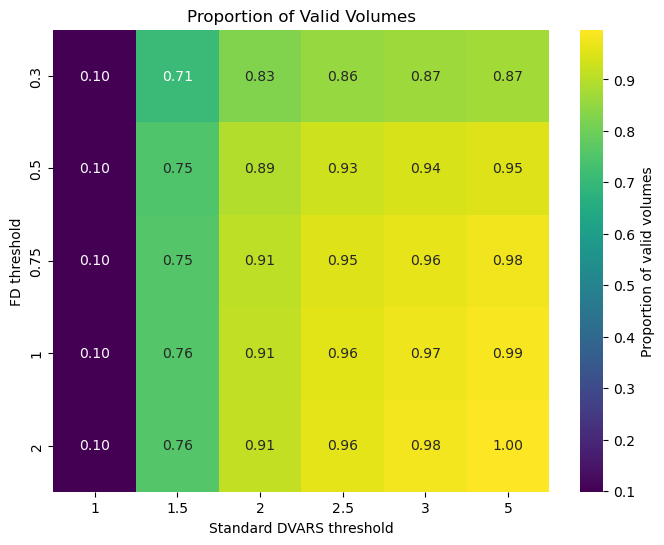

In [ ]:
# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(
    prop_valid, 
    xticklabels=std_dvars_thresholds, 
    yticklabels=fd_thresholds, 
    cmap="viridis", 
    annot=True,  # Automatically add numerical values
    fmt=".2f",  # Format numbers with 2 decimal places
    cbar_kws={'label': "Proportion of valid volumes"}  # Add label to colorbar
)

# Configure labels
plt.xlabel("Standard DVARS threshold")
plt.ylabel("FD threshold")
plt.title("Proportion of Valid Volumes")

plt.show()


In [20]:
scrubbed_volumes = (all_volumes - valid_volumes)/all_volumes

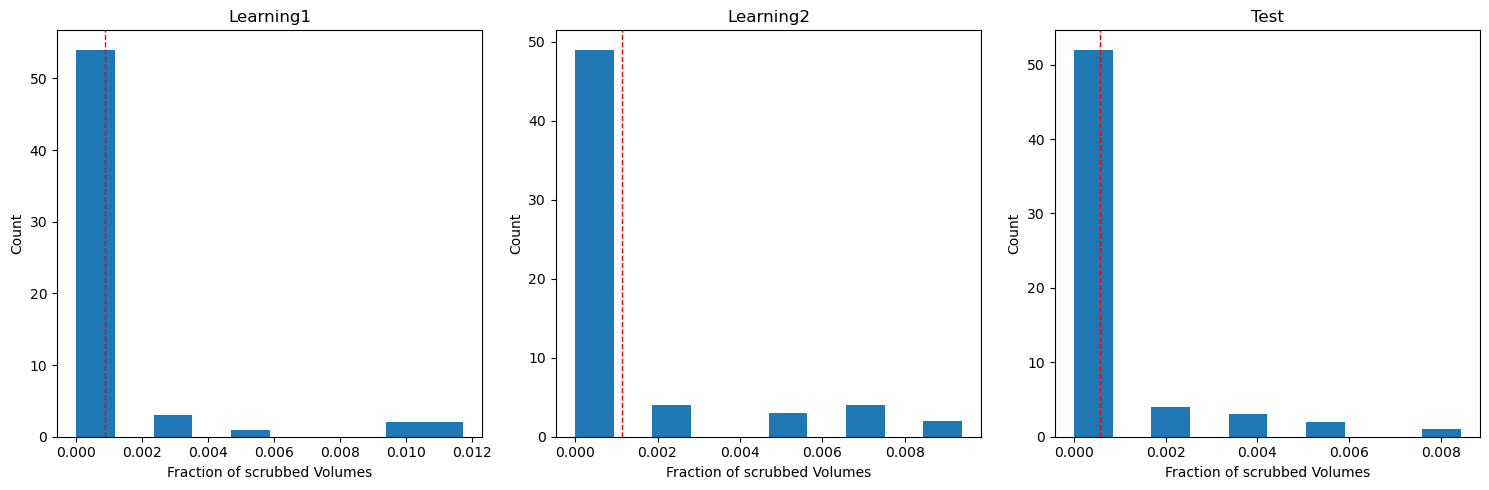

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(scrubbed_volumes[:, 0], bins=10, label='learning1')
axes[0].axvline(scrubbed_volumes[:, 0].mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_title('Learning1')
axes[0].set_xlabel('Fraction of scrubbed Volumes')
axes[0].set_ylabel('Count')

axes[1].hist(scrubbed_volumes[:, 1], bins=10, label='learning2')
axes[1].axvline(scrubbed_volumes[:, 1].mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_title('Learning2')
axes[1].set_xlabel('Fraction of scrubbed Volumes')
axes[1].set_ylabel('Count')

axes[2].hist(scrubbed_volumes[:, 2], bins=10, label='test')
axes[2].axvline(scrubbed_volumes[:, 2].mean(), color='red', linestyle='dashed', linewidth=1)
axes[2].set_title('Test')
axes[2].set_xlabel('Fraction of scrubbed Volumes')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
# exclusion threshold
max_scrub = 0.2

In [ ]:
for run in range(3):
    subject_ids = [sub_ids[i] for i in range(len(sub_ids)) if scrubbed_volumes[i, run] > max_scrub]
    print(f'Run {run+1}: {len(subject_ids)} subjects with > {max_scrub} scrubbed volumes')
    print(f'Subject IDs: {subject_ids}')
